In [1]:
import tensorflow as tf
print('TensorFlow Version: {}'.format(tf.__version__))
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.7.1
Default GPU Device: 


##### >**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [2]:
import numpy as np
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')

In [3]:
def model_input(state_size):
    #states = tf.placeholder(tf.float32, [None, *state_size], name='states')
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    actions = tf.placeholder(tf.int32, [None], name='actions')
    next_states = tf.placeholder(tf.float32, [None, state_size], name='next_states')
    # rewards = tf.placeholder(tf.float32, [None], name='rewards')
    dones = tf.placeholder(tf.float32, [None], name='dones')
    rates = tf.placeholder(tf.float32, [None], name='rates') # success rate
    return states, actions, next_states, dones, rates

In [6]:
def Act(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('Act', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        return logits

In [7]:
def Env(states, actions, state_size, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('Env', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=action_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        nl1_fused = tf.concat(axis=1, values=[nl1, actions])
        h2 = tf.layers.dense(inputs=nl1_fused, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
                
        # Output layer
        states_logits = tf.layers.dense(inputs=nl2, units=state_size, trainable=False)
        Qlogits = tf.layers.dense(inputs=nl2, units=1, trainable=False)
        return states_logits, Qlogits

In [8]:
def model_loss(state_size, action_size, hidden_size,
               states, actions, next_states, dones, rates):
    ################################################ a = act(s)
    actions_logits = Act(states=states, hidden_size=hidden_size, action_size=action_size)
    actions_labels = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    aloss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=actions_logits, 
                                                                      labels=actions_labels))
    ################################################ s', r = env(s, a)
    ################################################ ~s', Q = ~env(s, a)
    ################################################ ~s', Q = ~env(s, ~a)
    e_next_states_logits, eQs = Env(actions=actions_labels, states=states, hidden_size=hidden_size, 
                                    action_size=action_size, state_size=state_size)
    a_next_states_logits, aQs = Env(actions=actions_logits, states=states, hidden_size=hidden_size, 
                                    action_size=action_size, state_size=state_size, reuse=True)
    next_states_labels = tf.nn.sigmoid(next_states)
    eloss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=e_next_states_logits, 
                                                                   labels=next_states_labels))
    aloss2 = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=a_next_states_logits, 
                                                                    labels=next_states_labels))
    eQs_logits = tf.reshape(eQs, shape=[-1])
    aQs_logits = tf.reshape(aQs, shape=[-1])
    eloss += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=eQs_logits, # GAN
                                                                    labels=rates)) # 0-1
    eloss += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=aQs_logits, # GAN
                                                                    labels=tf.zeros_like(rates))) # min
    aloss2 += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=aQs_logits, # GAN
                                                                     labels=tf.ones_like(rates))) # max
    #################################################### s'', Q' = ~env(s', ~a')
    next_actions_logits = Act(states=next_states, hidden_size=hidden_size, action_size=action_size, reuse=True)
    _, aQs2 = Env(actions=next_actions_logits, states=next_states, hidden_size=hidden_size, 
                  action_size=action_size, state_size=state_size, reuse=True)
    aQs2_logits = tf.reshape(aQs2, shape=[-1]) * (1-dones)
    eloss += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=aQs2_logits, # GAN
                                                                    labels=tf.zeros_like(rates))) # min
    aloss2 += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=aQs2_logits, # GAN
                                                                     labels=tf.ones_like(rates))) # min
    return actions_logits, aloss, eloss, aloss2

In [9]:
def model_opt(a_loss, e_loss, a_loss2, a_learning_rate, e_learning_rate):
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    a_vars = [var for var in t_vars if var.name.startswith('Act')]
    e_vars = [var for var in t_vars if var.name.startswith('Env')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
        a_opt = tf.train.AdamOptimizer(a_learning_rate).minimize(a_loss, var_list=a_vars)
        e_opt = tf.train.AdamOptimizer(e_learning_rate).minimize(e_loss, var_list=e_vars)
        a_opt2 = tf.train.AdamOptimizer(a_learning_rate).minimize(a_loss2, var_list=a_vars)
    return a_opt, e_opt, a_opt2

In [10]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, a_learning_rate, e_learning_rate):

        # Data of the Model: make the data available inside the framework
        self.states, self.actions, self.next_states, self.dones, self.rates = model_input(state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.a_loss, self.e_loss, self.a_loss2 = model_loss(
            state_size=state_size, action_size=action_size, hidden_size=hidden_size, # model init
            states=self.states, actions=self.actions, next_states=self.next_states, 
            dones=self.dones, rates=self.rates) # model input
        
        # Update the model: backward pass and backprop
        self.a_opt, self.e_opt, self.a_opt2 = model_opt(a_loss=self.a_loss, 
                                                        e_loss=self.e_loss,
                                                        a_loss2=self.a_loss2, 
                                                        a_learning_rate=a_learning_rate,
                                                        e_learning_rate=e_learning_rate)

In [11]:
# def sample(buffer, batch_size):
#     idx = np.random.choice(np.arange(len(buffer)), size=batch_size, replace=False)
#     return [buffer[ii] for ii in idx]

In [12]:
from collections import deque
class Memory():
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size) # data batch

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [13]:
env.observation_space, env.action_space

(Box(4,), Discrete(2))

In [14]:
# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01           # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
state_size = 4
action_size = 2
hidden_size = 4*2             # number of units in each Q-network hidden layer
a_learning_rate = 1e-4         # Q-network learning rate
e_learning_rate = 1e-4         # Q-network learning rate

# Memory parameters
memory_size = int(1e5)            # memory capacity
batch_size = int(1e3)             # experience mini-batch size: 200/500 a successfull episode size
# gamma = 0.99                   # future reward discount

In [15]:
# Reset/init the graph/session
graph = tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, state_size=state_size, hidden_size=hidden_size,
              a_learning_rate=a_learning_rate, 
              e_learning_rate=e_learning_rate)

# Init the memory
memory = Memory(max_size=memory_size)

In [16]:
state = env.reset()
total_reward = 0
num_step = 0
for _ in range(memory_size):
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)
    rate = -1
    memory.buffer.append([state, action, next_state, reward, float(done), rate])
    num_step += 1 # memory incremented
    total_reward += reward
    state = next_state
    if done is True:
        state = env.reset()
        rate = total_reward/500
        for idx in range(num_step): # episode length
            if memory.buffer[-1-idx][-1] == -1:
                memory.buffer[-1-idx][-1] = rate
        total_reward = 0 # reset
        num_step = 0 # reset

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [19]:
# Save/load the model and save for plotting
saver = tf.train.Saver()
episode_rewards_list, rewards_list = [], []
aloss_list, eloss_list, aloss2_list = [], [], []

# TF session for training
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    total_step = 0 # Explore or exploit parameter
    episode_reward = deque(maxlen=100) # 100 episodes average/running average/running mean/window

    # Training episodes/epochs
    for ep in range(11111):
        total_reward = 0 # each episode
        aloss_batch, eloss_batch, aloss2_batch = [], [], []
        state = env.reset() # each episode
        num_step = 0 # each episode
        rate = -1

        # Training steps/batches
        while True:
            # Explore (env) or Exploit (model)
            total_step += 1
            explore_p = explore_stop + (explore_start - explore_stop) * np.exp(-decay_rate * total_step) 
            if explore_p > np.random.rand():
                action = env.action_space.sample()
            else:
                action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
                action = np.argmax(action_logits)
            next_state, reward, done, _ = env.step(action)
            memory.buffer.append([state, action, next_state, reward, float(done), rate])
            num_step += 1 # momory added
            total_reward += reward
            state = next_state
            
            # Training with the maxrated minibatch
            batch = memory.buffer
            #for idx in range(memory_size// batch_size):
            while True:
                idx = np.random.choice(np.arange(memory_size// batch_size))
                states = np.array([each[0] for each in batch])[idx*batch_size:(idx+1)*batch_size]
                actions = np.array([each[1] for each in batch])[idx*batch_size:(idx+1)*batch_size]
                next_states = np.array([each[2] for each in batch])[idx*batch_size:(idx+1)*batch_size]
                #rewards = np.array([each[3] for each in batch])[idx*batch_size:(idx+1)*batch_size]
                dones = np.array([each[4] for each in batch])[idx*batch_size:(idx+1)*batch_size]
                rates = np.array([each[5] for each in batch])[idx*batch_size:(idx+1)*batch_size]
                states = states[rates >= np.max(rates)]
                actions = actions[rates >= np.max(rates)]
                next_states = next_states[rates >= np.max(rates)]
                #rewards = rewards[rates >= np.max(rates)]
                dones = dones[rates >= np.max(rates)]
                rates = rates[rates >= np.max(rates)]
                if np.count_nonzero(dones) > 0 and len(dones) > 1 and np.max(rates) > 0:
                    break
            aloss, _ = sess.run([model.a_loss, model.a_opt],
                                feed_dict = {model.states: states, 
                                            model.actions: actions,
                                            model.next_states: next_states,
                                            #model.rewards: rewards,
                                            model.dones: dones,
                                            model.rates: rates})
            eloss, _ = sess.run([model.e_loss, model.e_opt],
                                  feed_dict = {model.states: states, 
                                               model.actions: actions,
                                               model.next_states: next_states,
                                               #model.rewards: rewards,
                                               model.dones: dones,
                                               model.rates: rates})
            aloss2, _= sess.run([model.a_loss2, model.a_opt2], 
                                 feed_dict = {model.states: states, 
                                              model.actions: actions,
                                              model.next_states: next_states,
                                              #model.rewards: rewards,
                                              model.dones: dones,
                                              model.rates: rates})
            # print('dones:', 
            #       len(dones), np.count_nonzero(dones), 
            #       len(dones1), np.count_nonzero(dones1), 
            #       len(dones2), np.count_nonzero(dones2))
            aloss_batch.append(aloss)
            eloss_batch.append(eloss)
            aloss2_batch.append(aloss2)
            if done is True:
                break
                
        # Rating the latest played episode
        rate = total_reward/500 # update rate at the end/ when episode is done
        for idx in range(num_step): # episode length
            if memory.buffer[-1-idx][-1] == -1: # double-check the landmark/marked indexes
                memory.buffer[-1-idx][-1] = rate # rate the trajectory/data
                
        episode_reward.append(total_reward)
        print('Episode:{}'.format(ep),
              'meanR:{:.4f}'.format(np.mean(episode_reward)),
              'R:{:.4f}'.format(total_reward),
              'rate:{:.4f}'.format(rate),
              'aloss:{:.4f}'.format(np.mean(aloss_batch)),
              'eloss:{:.4f}'.format(np.mean(eloss_batch)),
              'aloss2:{:.4f}'.format(np.mean(aloss2_batch)),
              'exploreP:{:.4f}'.format(explore_p))

        # Ploting out
        episode_rewards_list.append([ep, np.mean(episode_reward)])
        rewards_list.append([ep, total_reward])
        aloss_list.append([ep, np.mean(aloss_batch)])
        eloss_list.append([ep, np.mean(eloss_batch)])
        aloss2_list.append([ep, np.mean(aloss2_batch)])
        
        # Break episode/epoch loop
        ## Option 1: Solve the First Version
        #The task is episodic, and in order to solve the environment, 
        #your agent must get an average score of +30 over 100 consecutive episodes.
        if np.mean(episode_reward) >= 500:
            break
            
    # At the end of all training episodes/epochs
    saver.save(sess, 'checkpoints/model.ckpt')

Episode:0 meanR:26.0000 R:26.0000 rate:0.0520 aloss:0.6835 dloss:2.6310 aloss2:2.1113 exploreP:0.9974
Episode:1 meanR:19.0000 R:12.0000 rate:0.0240 aloss:0.6783 dloss:2.6240 aloss2:2.1206 exploreP:0.9962
Episode:2 meanR:18.3333 R:17.0000 rate:0.0340 aloss:0.6851 dloss:2.6242 aloss2:2.1216 exploreP:0.9946
Episode:3 meanR:17.5000 R:15.0000 rate:0.0300 aloss:0.6882 dloss:2.5946 aloss2:2.1399 exploreP:0.9931
Episode:4 meanR:23.4000 R:47.0000 rate:0.0940 aloss:0.6840 dloss:2.5867 aloss2:2.1448 exploreP:0.9885
Episode:5 meanR:21.8333 R:14.0000 rate:0.0280 aloss:0.6829 dloss:2.5809 aloss2:2.1560 exploreP:0.9871
Episode:6 meanR:21.2857 R:18.0000 rate:0.0360 aloss:0.6848 dloss:2.5655 aloss2:2.1576 exploreP:0.9854
Episode:7 meanR:24.8750 R:50.0000 rate:0.1000 aloss:0.6813 dloss:2.5450 aloss2:2.1806 exploreP:0.9805
Episode:8 meanR:24.6667 R:23.0000 rate:0.0460 aloss:0.6862 dloss:2.5269 aloss2:2.1945 exploreP:0.9783
Episode:9 meanR:24.3000 R:21.0000 rate:0.0420 aloss:0.6871 dloss:2.5172 aloss2:2.2

Episode:80 meanR:22.4321 R:15.0000 rate:0.0300 aloss:0.6856 dloss:1.6513 aloss2:3.7356 exploreP:0.8355
Episode:81 meanR:22.9390 R:64.0000 rate:0.1280 aloss:0.6857 dloss:1.6418 aloss2:3.7120 exploreP:0.8302
Episode:82 meanR:22.7831 R:10.0000 rate:0.0200 aloss:0.6830 dloss:1.6269 aloss2:3.8443 exploreP:0.8294
Episode:83 meanR:22.8452 R:28.0000 rate:0.0560 aloss:0.6927 dloss:1.6204 aloss2:3.8125 exploreP:0.8271
Episode:84 meanR:22.8000 R:19.0000 rate:0.0380 aloss:0.6851 dloss:1.6051 aloss2:3.8160 exploreP:0.8256
Episode:85 meanR:23.0116 R:41.0000 rate:0.0820 aloss:0.6870 dloss:1.6144 aloss2:3.8791 exploreP:0.8222
Episode:86 meanR:22.9310 R:16.0000 rate:0.0320 aloss:0.6841 dloss:1.5679 aloss2:3.9807 exploreP:0.8209
Episode:87 meanR:23.2386 R:50.0000 rate:0.1000 aloss:0.6877 dloss:1.5950 aloss2:3.9836 exploreP:0.8169
Episode:88 meanR:23.1348 R:14.0000 rate:0.0280 aloss:0.6808 dloss:1.6169 aloss2:4.0207 exploreP:0.8158
Episode:89 meanR:23.1111 R:21.0000 rate:0.0420 aloss:0.6807 dloss:1.5627 

Episode:159 meanR:33.8100 R:15.0000 rate:0.0300 aloss:0.7131 dloss:1.2490 aloss2:6.4333 exploreP:0.6235
Episode:160 meanR:34.1900 R:55.0000 rate:0.1100 aloss:0.6878 dloss:1.2661 aloss2:6.5573 exploreP:0.6202
Episode:161 meanR:34.5600 R:52.0000 rate:0.1040 aloss:0.6621 dloss:1.2953 aloss2:6.5106 exploreP:0.6170
Episode:162 meanR:34.9000 R:56.0000 rate:0.1120 aloss:0.6804 dloss:1.2454 aloss2:6.4311 exploreP:0.6136
Episode:163 meanR:35.1000 R:30.0000 rate:0.0600 aloss:0.6794 dloss:1.2645 aloss2:6.1928 exploreP:0.6118
Episode:164 meanR:36.1300 R:128.0000 rate:0.2560 aloss:0.6876 dloss:1.2674 aloss2:6.4752 exploreP:0.6041
Episode:165 meanR:36.2100 R:25.0000 rate:0.0500 aloss:0.6826 dloss:1.2768 aloss2:6.7128 exploreP:0.6027
Episode:166 meanR:36.1200 R:24.0000 rate:0.0480 aloss:0.6913 dloss:1.2688 aloss2:6.5427 exploreP:0.6012
Episode:167 meanR:36.4500 R:51.0000 rate:0.1020 aloss:0.7051 dloss:1.2877 aloss2:6.7519 exploreP:0.5982
Episode:168 meanR:36.7400 R:48.0000 rate:0.0960 aloss:0.7033 dl

Episode:238 meanR:218.3400 R:500.0000 rate:1.0000 aloss:0.6647 dloss:1.6430 aloss2:5.3930 exploreP:0.0860
Episode:239 meanR:222.6200 R:500.0000 rate:1.0000 aloss:0.6583 dloss:1.7537 aloss2:5.3281 exploreP:0.0823
Episode:240 meanR:226.6600 R:500.0000 rate:1.0000 aloss:0.6589 dloss:1.7146 aloss2:5.2232 exploreP:0.0788
Episode:241 meanR:231.5100 R:500.0000 rate:1.0000 aloss:0.6614 dloss:1.6550 aloss2:5.2503 exploreP:0.0754
Episode:242 meanR:236.1100 R:500.0000 rate:1.0000 aloss:0.6563 dloss:1.7212 aloss2:5.2019 exploreP:0.0723
Episode:243 meanR:240.9900 R:500.0000 rate:1.0000 aloss:0.6561 dloss:1.7008 aloss2:5.1969 exploreP:0.0692
Episode:244 meanR:245.7800 R:500.0000 rate:1.0000 aloss:0.6566 dloss:1.6644 aloss2:5.1802 exploreP:0.0663
Episode:245 meanR:250.4000 R:500.0000 rate:1.0000 aloss:0.6561 dloss:1.6810 aloss2:5.2413 exploreP:0.0636
Episode:246 meanR:254.9500 R:500.0000 rate:1.0000 aloss:0.6574 dloss:1.6800 aloss2:5.2452 exploreP:0.0610
Episode:247 meanR:259.2400 R:500.0000 rate:1.0

Episode:316 meanR:439.8700 R:500.0000 rate:1.0000 aloss:0.5782 dloss:2.1216 aloss2:4.0674 exploreP:0.0128
Episode:317 meanR:435.9200 R:105.0000 rate:0.2100 aloss:0.5944 dloss:2.0464 aloss2:4.0293 exploreP:0.0127
Episode:318 meanR:432.0400 R:112.0000 rate:0.2240 aloss:0.5956 dloss:2.0730 aloss2:4.0834 exploreP:0.0127
Episode:319 meanR:433.5200 R:500.0000 rate:1.0000 aloss:0.5652 dloss:2.2019 aloss2:4.0001 exploreP:0.0126
Episode:320 meanR:433.5200 R:500.0000 rate:1.0000 aloss:0.5883 dloss:2.0876 aloss2:4.0755 exploreP:0.0124
Episode:321 meanR:433.5200 R:500.0000 rate:1.0000 aloss:0.5757 dloss:2.1602 aloss2:4.0022 exploreP:0.0123
Episode:322 meanR:433.5200 R:500.0000 rate:1.0000 aloss:0.5748 dloss:2.1645 aloss2:3.9704 exploreP:0.0122
Episode:323 meanR:433.5200 R:500.0000 rate:1.0000 aloss:0.5795 dloss:2.1098 aloss2:4.0391 exploreP:0.0121
Episode:324 meanR:430.0500 R:153.0000 rate:0.3060 aloss:0.5673 dloss:2.2010 aloss2:3.9700 exploreP:0.0121
Episode:325 meanR:430.0500 R:500.0000 rate:1.0

Episode:394 meanR:395.7800 R:500.0000 rate:1.0000 aloss:0.4849 dloss:2.4443 aloss2:3.2654 exploreP:0.0101
Episode:395 meanR:395.0500 R:283.0000 rate:0.5660 aloss:0.4780 dloss:2.4570 aloss2:3.2573 exploreP:0.0101
Episode:396 meanR:393.9300 R:159.0000 rate:0.3180 aloss:0.4677 dloss:2.4869 aloss2:3.2100 exploreP:0.0101
Episode:397 meanR:392.5200 R:359.0000 rate:0.7180 aloss:0.4687 dloss:2.4728 aloss2:3.2193 exploreP:0.0101
Episode:398 meanR:388.8500 R:133.0000 rate:0.2660 aloss:0.4958 dloss:2.4080 aloss2:3.3051 exploreP:0.0101
Episode:399 meanR:388.8500 R:500.0000 rate:1.0000 aloss:0.4635 dloss:2.4961 aloss2:3.1925 exploreP:0.0101
Episode:400 meanR:386.3600 R:251.0000 rate:0.5020 aloss:0.4798 dloss:2.4499 aloss2:3.2240 exploreP:0.0101
Episode:401 meanR:385.7700 R:441.0000 rate:0.8820 aloss:0.4763 dloss:2.4727 aloss2:3.2198 exploreP:0.0101
Episode:402 meanR:389.8200 R:500.0000 rate:1.0000 aloss:0.4678 dloss:2.4797 aloss2:3.1883 exploreP:0.0101
Episode:403 meanR:391.2900 R:500.0000 rate:1.0

Episode:472 meanR:447.8800 R:500.0000 rate:1.0000 aloss:0.4204 dloss:2.4625 aloss2:3.0830 exploreP:0.0100
Episode:473 meanR:446.7600 R:388.0000 rate:0.7760 aloss:0.4205 dloss:2.4565 aloss2:3.0967 exploreP:0.0100
Episode:474 meanR:446.7600 R:500.0000 rate:1.0000 aloss:0.4189 dloss:2.4536 aloss2:3.1042 exploreP:0.0100
Episode:475 meanR:446.7600 R:500.0000 rate:1.0000 aloss:0.4161 dloss:2.4480 aloss2:3.1156 exploreP:0.0100
Episode:476 meanR:446.7600 R:500.0000 rate:1.0000 aloss:0.4167 dloss:2.4477 aloss2:3.1194 exploreP:0.0100
Episode:477 meanR:446.7600 R:500.0000 rate:1.0000 aloss:0.4152 dloss:2.4448 aloss2:3.1318 exploreP:0.0100
Episode:478 meanR:446.7600 R:500.0000 rate:1.0000 aloss:0.4139 dloss:2.4414 aloss2:3.1446 exploreP:0.0100
Episode:479 meanR:446.8400 R:500.0000 rate:1.0000 aloss:0.4131 dloss:2.4391 aloss2:3.1514 exploreP:0.0100
Episode:480 meanR:446.8400 R:500.0000 rate:1.0000 aloss:0.4116 dloss:2.4395 aloss2:3.1578 exploreP:0.0100
Episode:481 meanR:446.8400 R:500.0000 rate:1.0

Episode:550 meanR:492.4100 R:500.0000 rate:1.0000 aloss:0.3967 dloss:2.3108 aloss2:3.6623 exploreP:0.0100
Episode:551 meanR:492.4100 R:500.0000 rate:1.0000 aloss:0.3962 dloss:2.3103 aloss2:3.6654 exploreP:0.0100
Episode:552 meanR:492.4100 R:500.0000 rate:1.0000 aloss:0.3988 dloss:2.3063 aloss2:3.6935 exploreP:0.0100
Episode:553 meanR:492.4100 R:500.0000 rate:1.0000 aloss:0.3940 dloss:2.3049 aloss2:3.6907 exploreP:0.0100
Episode:554 meanR:492.4100 R:500.0000 rate:1.0000 aloss:0.3982 dloss:2.3032 aloss2:3.7113 exploreP:0.0100
Episode:555 meanR:493.7000 R:500.0000 rate:1.0000 aloss:0.3958 dloss:2.3034 aloss2:3.7129 exploreP:0.0100
Episode:556 meanR:493.7000 R:500.0000 rate:1.0000 aloss:0.3963 dloss:2.2955 aloss2:3.7395 exploreP:0.0100
Episode:557 meanR:493.7000 R:500.0000 rate:1.0000 aloss:0.3950 dloss:2.2981 aloss2:3.7420 exploreP:0.0100
Episode:558 meanR:493.7000 R:500.0000 rate:1.0000 aloss:0.3956 dloss:2.2996 aloss2:3.7503 exploreP:0.0100
Episode:559 meanR:493.7000 R:500.0000 rate:1.0

Episode:628 meanR:493.8100 R:500.0000 rate:1.0000 aloss:0.3755 dloss:2.2475 aloss2:4.0540 exploreP:0.0100
Episode:629 meanR:493.8100 R:500.0000 rate:1.0000 aloss:0.3761 dloss:2.2440 aloss2:4.0854 exploreP:0.0100
Episode:630 meanR:493.8100 R:500.0000 rate:1.0000 aloss:0.3744 dloss:2.2441 aloss2:4.0862 exploreP:0.0100
Episode:631 meanR:493.8100 R:500.0000 rate:1.0000 aloss:0.3753 dloss:2.2437 aloss2:4.1019 exploreP:0.0100
Episode:632 meanR:493.8100 R:500.0000 rate:1.0000 aloss:0.3738 dloss:2.2390 aloss2:4.1451 exploreP:0.0100
Episode:633 meanR:493.8100 R:500.0000 rate:1.0000 aloss:0.3735 dloss:2.2399 aloss2:4.1052 exploreP:0.0100
Episode:634 meanR:493.8100 R:500.0000 rate:1.0000 aloss:0.3725 dloss:2.2434 aloss2:4.1150 exploreP:0.0100
Episode:635 meanR:493.8100 R:500.0000 rate:1.0000 aloss:0.3740 dloss:2.2386 aloss2:4.1586 exploreP:0.0100
Episode:636 meanR:493.8100 R:500.0000 rate:1.0000 aloss:0.3728 dloss:2.2372 aloss2:4.1621 exploreP:0.0100
Episode:637 meanR:493.8100 R:500.0000 rate:1.0

# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [20]:
import matplotlib.pyplot as plt
%matplotlib inline

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

Text(0, 0.5, 'Total rewards')

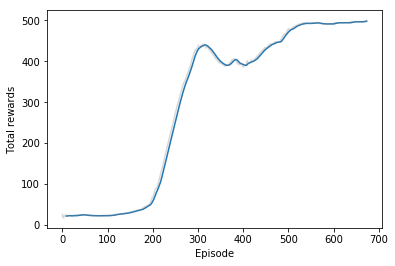

In [27]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

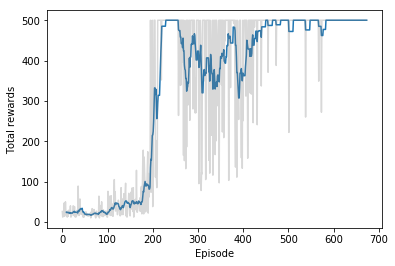

In [28]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Act losses')

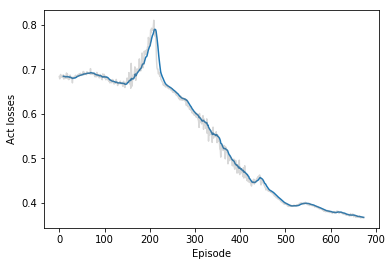

In [29]:
eps, arr = np.array(aloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Act losses')

Text(0, 0.5, 'Env losses')

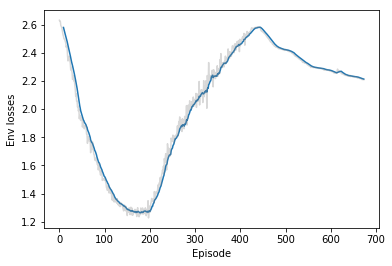

In [30]:
eps, arr = np.array(eloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Env losses')

Text(0, 0.5, 'Act losses 2')

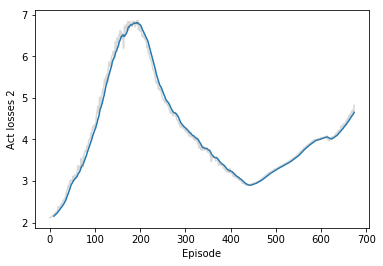

In [31]:
eps, arr = np.array(aloss2_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Act losses 2')

## Testing

Let's checkout how our trained agent plays the game.

In [32]:
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Episodes/epochs
    for _ in range(10):
        state = env.reset()
        total_reward = 0

        # Steps/batches
        while True:
            env.render()
            action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
            action = np.argmax(action_logits)
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done:
                print('total_reward: {}'.format(total_reward))
                break
                
env.close()

INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt
total_reward: 22.0
total_reward: 29.0
total_reward: 31.0
total_reward: 26.0
total_reward: 31.0
total_reward: 33.0
total_reward: 27.0
total_reward: 28.0
total_reward: 29.0
total_reward: 34.0
